In [1]:
#Cleaned out form of Code pulled from Yuqi's archive

#Preliminary Setup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import numpy.matlib as npmat
import random
from scipy.stats import ttest_ind, sem, chi2, pearsonr, spearmanr
from statsmodels.stats.multitest import multipletests

red = (214/255, 33/255, 98/255)
blue = (71/255, 124/255, 191/255)

# Load the Excel file
#file_path = '/Users/yuqi/Downloads/5xFAD/Group plotting/NeuN_Abeta_corrToRob.xlsx'
# actually had to pull this file from /Volumes/All_Staff/civmGradStudents/YuqiLaptop/Dropbox/YuqiMac/Deprecated\ \(part\ of\ downloads\)/5xFAD/Group\ plotting/NeuN_Abeta_corrToRob.xlsx 
file_path = '../Investigating_Yuqi_Data/Original_Yuqi_DataSheets/NeuN_Abeta_corrToRob_removeextrasub.xlsx'
data = pd.read_excel(file_path)

val=data['Shorts']=='cn7'
true_indices = [i for i, val in enumerate(val) if val is True]

for i, true_idx in enumerate(true_indices):
    data.loc[true_indices[i], 'Shorts']='FMN'
    data.loc[true_indices[i], 'Structure']='FMN__Facial_motor_nucleus_left'
    
# Create NeuN_num column
data['NeuN_num'] = data['NeuNDensity_Mean'] * 1000 * data['volume_mm3']

regions =['BLA', 'VCP', 'VCS','AON','PIC','CA3', 'EPF','SUB','ACC','CA1','NAC','LSN','SUT','FMN','HGN','PFT','MGD','RED','AVT','POT','cst','mel']
targets = ['volume_mm3','NeuN_num','NeuNDensity_Mean', 'Abeta_Mean'] 

In [2]:
# Helper Functions

def fisher_combined(individual_p_values):
    chi2_stat = -2 * np.sum(np.log(individual_p_values))
    combined_p_value = chi2.sf(chi2_stat, 2 * len(individual_p_values))
    return combined_p_value

def correlation(x,y,x_name,y_name,corr_type,delineation_name):
    if corr_type == 'spearman':
        rho, pval = spearmanr(x, y)

        entry = {'x_metric': x_name,
            'y_metric': y_name,
            'additional_delineation': delineation_name,
            'correlation type': 'spearman',
            'rho': rho,
            'pvalue': pval
        }
    if corr_type == 'pearson':
        r, pval = pearsonr(x, y)

        entry = {'x_metric': x_name,
            'y_metric': y_name,
            'additional_delineation': delineation_name,
            'correlation type': 'pearson',
            'r': r,
            'pvalue': pval
        }
    return entry

def make_summary_table (grouped):
    pivoted = grouped.pivot(index='Region', columns='Gene_condition')
    
    change_df = pd.DataFrame({
    'Volume_change': (pivoted['Volume']['Tg'] - pivoted['Volume']['nTg']),
    'Neuron_Density_change': (pivoted['Neuron_Density']['Tg'] - pivoted['Neuron_Density']['nTg']),
    'Neuron_Number_change': (pivoted['Neuron_Number']['Tg'] - pivoted['Neuron_Number']['nTg']),
    'Abeta_load_Tg': pivoted['Abeta_load']['Tg']
}).dropna()
    
    return change_df 

In [3]:
#Create Pvalues for t-test and percent changes

individual_p_values = []
data_keep = [{}]
data_keep_fa=[{}]
regions_num=[]
for con, target in enumerate(targets):
    relative_diff = []
    relative_diff_sem = []  # For error bars
    relative_foldchange_sem = []
    
    for i, region in enumerate(regions):
        # Filter data for AD and Non-AD groups for the current region
        ad_data = data[(data['Shorts'] == region) & (data['Gene_condition'] == 'AD')][target]
        non_ad_data = data[(data['Shorts'] == region) & (data['Gene_condition'] == 'Non-AD')][target]

        structure_name= data['Structure'][(data['Shorts'] == region) & (data['Gene_condition'] == 'AD')].unique()

        ad_mean = np.mean(ad_data)
        non_ad_mean = np.mean(non_ad_data)
        
        ad_std = np.std(ad_data)
        non_ad_std = np.std(non_ad_data)

        if non_ad_mean != 0:  # Avoid division by zero
            diff = (ad_mean - non_ad_mean) / non_ad_mean
            relative_diff.append(diff)
            # SEM calculation
            combined_data = (ad_data - non_ad_data.mean()) / non_ad_mean
            relative_diff_sem.append(sem(combined_data, nan_policy='omit'))
            
            combined_data_FoldChange = []
            num = np.array(ad_data)
            denom = np.array(non_ad_data)
            for i in range(len(denom)):
                combined_data_FoldChange.append(num/denom[i])
                tempFC=np.array(combined_data_FoldChange) 
                relative_foldchange_sem.append(np.std(tempFC)/(np.sqrt(len(num)*len(denom))))
        
        else:
            relative_diff.append(np.nan)
            relative_diff_sem.append(np.nan)
            
        if len(ad_data) > 0 and len(non_ad_data) > 0:
            # t-test
            t_stat, p_value = ttest_ind(ad_data, non_ad_data, nan_policy='omit', equal_var=False)
            individual_p_values.append(p_value)
            pvalf=p_value
        else:
            individual_p_values.append(np.nan)
            pvalf=np.nan
               
        if target == 'volume_mm3':
            temp=data[(data['Shorts'] == region) & (data['Gene_condition'] == 'AD')]
            FAD_fa_data=data[(data['Shorts'] == region) & (data['Gene_condition'] == 'AD')]['fa_mean']
            nTG_fa_data=data[(data['Shorts'] == region) & (data['Gene_condition'] == 'Non-AD')]['fa_mean']

            regions_num.append(temp['Region'].unique())
            
            FAD_fa_data_mean = np.mean(FAD_fa_data)
            nTG_fa_data_mean = np.mean(nTG_fa_data)

            fa_diff = (FAD_fa_data_mean - nTG_fa_data_mean) / nTG_fa_data_mean
            # SEM calculation
            fa_diff_2 = (FAD_fa_data - nTG_fa_data_mean) / nTG_fa_data_mean # how each FAD varies from mean nTG 
            
            combined_FA_PerChange = []
            num = np.array(ad_data)
            denom = np.array(non_ad_data)
            for i in range(len(denom)):
                combined_FA_PerChange.append((num-denom[i])/denom[i])
                tempPC_FA=np.array(combined_FA_PerChange)           

            entry_fa={'Structure': str("").join(structure_name),'Abbreviation': region,'Relative_Diff FA wrt nTG':fa_diff,'SEM --Yuqi Form how each FAD varies from mean nTG': sem(fa_diff_2, nan_policy='omit'),'SEM --KH Form indiv2indiv':np.std(tempPC_FA)/(np.sqrt(len(num)*len(denom)))} # Yuqi sem is equvilant to np.std(fa_diff_2)/np.sqrt(8)) -- why 8 and not 7 or 9? 
            data_keep_fa.append(entry_fa)

        entry = {'Structure': str("").join(structure_name),'Abbreviation': region, 'Contrast': target, 'T-Stat': t_stat,'Pvalue':pvalf, 'Relative_Diff wrt nTG': diff,'SEM --Yuqi Form how each FAD varies from mean nTG': sem(combined_data, nan_policy='omit'),'Mean Fold-Change':ad_mean/non_ad_mean,'SEM --KH Form indiv2indiv_sameforfold&percent':np.std(tempFC)/(np.sqrt(len(num)*len(denom))), 'FAD_mean': ad_mean,'nTG_mean':non_ad_mean,'FAD_std': ad_std,'nTG_std':non_ad_std}
        data_keep.append(entry)

df_fa=pd.DataFrame(data_keep_fa)
df_fa = df_fa[1:] #cleans out preallocation row
df_fa.to_csv('../Investigating_Yuqi_Data/Running_Python_Outputs/Saved_PerChange_FA_for_Figure6g.csv', index=True)
                          
df = pd.DataFrame(data_keep)
df = df[1:] #cleans out preallocation row

H0, Pvalue_BH,Sidak_Alpha,Bonferroni_Alpha=multipletests(individual_p_values, alpha=0.05, method='fdr_bh')
df.insert(loc=5, column='Pvalue_BH', value=Pvalue_BH)

H0, Pvalue_Bonferroni,Sidak_Alpha,Bonferroni_Alpha=multipletests(individual_p_values, alpha=0.05, method='bonferroni')
df.insert(loc=5, column='Pvalue_Bonferroni', value=Pvalue_Bonferroni)

df.to_csv('../Investigating_Yuqi_Data/Running_Python_Outputs/Saved_T_Test_Results_for_Figure6.csv', index=True)

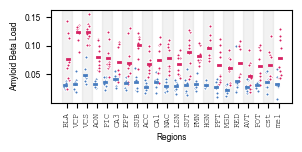

In [4]:
# Set plotting target
target = 'Abeta_Mean'
target_name = 'Amyloid_beta_load'
target_ylabel = 'Amyloid Beta Load'

# Colors
ntg_color = blue
tg_color = red

# Prepare figure for plotting
plt.rcParams.update({'font.size': 6, 'font.family': 'Arial'})
plt.rcParams['text.usetex'] = False
plt.rcParams['svg.fonttype'] = 'none'  # Keep SVG text editable

fig, ax = plt.subplots(figsize=(3, 1.5))

# Plot background bands
for i in range(len(regions)):
    if i % 2 == 0:
        ax.axvspan(i + 0.5, i + 1.5, color='gray', alpha=0.1)

# Plot data for each region
for i, region in enumerate(regions):
    ntg_data = data[(data['Shorts'] == region) & (data['Gene_condition'] == 'Non-AD')][target]
    tg_data = data[(data['Shorts'] == region) & (data['Gene_condition'] == 'AD')][target]

    jitter = lambda: random.uniform(-0.1, 0.1)
        
    # Plot NTg points
    ax.scatter([i + 0.85 + jitter() for _ in ntg_data], ntg_data,s=5, color=ntg_color, linewidths=0.75, edgecolor='w',
               label='NTg' if i == 0 else "", alpha=1)

    # Plot Tg points
    ax.scatter([i + 1.15 + jitter() for _ in tg_data], tg_data,s=5, color=tg_color,linewidths=0.75, edgecolor='w',
               label='Tg' if i == 0 else "", alpha=1)

    # Plot group means
    if len(ntg_data) > 0:
        ax.plot([i + 0.75, i + 0.95], [ntg_data.mean()] * 2, color=blue, linewidth=2)
    if len(tg_data) > 0:
        ax.plot([i + 1.05, i + 1.25], [tg_data.mean()] * 2, color=red, linewidth=2) 

    # Optional: compute and display p-value
    if len(ntg_data) > 0 and len(tg_data) > 0:
        _, p_value = ttest_ind(ntg_data, tg_data, nan_policy='omit')
        # Uncomment if you want to show p-values:
        # ax.text(i + 1, max(max(tg_data), max(ntg_data)) + 5, f'p={p_value:.3f}', ha='center', fontsize=7, color='red')

# Customize plot appearance
ax.set_xticks(np.arange(len(regions)) + 1)
ax.set_xticklabels(regions, rotation=90,fontname='Courier New')
ax.set_xlabel('Regions')
ax.set_ylabel(target_ylabel)
#ax.legend() -- legends don't go on graphs for journals typically

# Save the figure
save_path = '../Investigating_Yuqi_Data/Running_Python_Outputs/Indiv_ABeta_Dots_2025_10_16.svg'
plt.savefig(save_path, dpi=600)

# Display plot
plt.tight_layout()
plt.show()

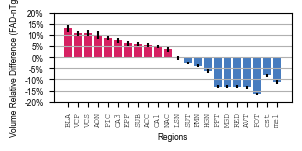

In [5]:
relative_diff = []
relative_diff_sem = []

for i, region in enumerate(regions):
    # Filter data for AD and Non-AD groups for the current region
    ad_data = data[(data['Shorts'] == region) & (data['Gene_condition'] == 'AD')]['volume_mm3']
    non_ad_data = data[(data['Shorts'] == region) & (data['Gene_condition'] == 'Non-AD')]['volume_mm3']

    ad_mean = np.mean(ad_data)
    non_ad_mean = np.mean(non_ad_data)

    if non_ad_mean != 0:  # Avoid division by zero
        relative_diff.append((ad_mean - non_ad_mean) / non_ad_mean)
        #combined_data = (ad_data - non_ad_data.mean()) / non_ad_mean
        #relative_diff_sem.append(sem(combined_data, nan_policy='omit'))
        
        combined_data = []
        num = np.array(ad_data)
        denom = np.array(non_ad_data)
        for i in range(len(denom)):
            combined_data.append(num/denom[i])

        temp=np.array(combined_data) 
        relative_diff_sem.append(np.std(temp)/(np.sqrt(len(num)*len(denom))))
    else:
        relative_diff.append(np.nan)  # Handle zero denominator case

plt.rcParams['svg.fonttype'] = 'none'  # Keep SVG text editable
        
# Define figure and axes for plotting
fig, ax = plt.subplots(figsize=(3, 1.5))

# Plot the relative difference
    
ax.bar(regions[0:11], relative_diff[0:11], color=red,yerr=relative_diff_sem[0:11])
ax.bar(regions[11], relative_diff[11], color='grey',yerr=relative_diff_sem[11])
ax.bar(regions[12:], relative_diff[12:], color=blue,yerr=relative_diff_sem[12:])

ax.grid(axis='y',zorder=0)

# Customize plot appearance
ax.set_xticks(np.arange(len(regions)))

#adjusted_region=regions.copy()
#adjusted_region[-9]='FMN'

ax.set_ylim(-.20,.20)

lin_dat=np.linspace(-.20,.20,9)
lin_dat_formatted=[]
for lin in lin_dat:
    lin_dat_formatted.append(f"{lin:.0%}")
ax.set_yticks(lin_dat)
ax.set_yticklabels(lin_dat_formatted,fontsize=6, fontname='Arial')

#ax.set_xticklabels(adjusted_region, rotation=90, fontsize=6, fontname='Courier New')
ax.set_xticklabels(regions, rotation=90, fontsize=6, fontname='Courier New')

ax.set_xlabel('Regions', fontsize=6, fontname='Arial')
ax.set_ylabel('Volume Relative Difference (FAD-nTg)/nTg', fontsize=6, fontname='Arial')

save_path = '../Investigating_Yuqi_Data/Running_Python_Outputs/Volume_relative_mean_diff_AD_non_AD.svg'
plt.savefig(save_path, dpi=600)

# Display plot
plt.tight_layout()
plt.show()

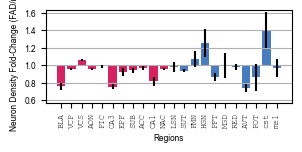

In [6]:
relative_diff = []
relative_diff_sem = []
for i, region in enumerate(regions):
    # Filter data for AD and Non-AD groups for the current region
    ad_data = data[(data['Shorts'] == region) & (data['Gene_condition'] == 'AD')]['NeuNDensity_Mean']
    non_ad_data = data[(data['Shorts'] == region) & (data['Gene_condition'] == 'Non-AD')]['NeuNDensity_Mean']

    ad_mean = np.mean(ad_data)
    non_ad_mean = np.mean(non_ad_data)

    if non_ad_mean != 0:  # Avoid division by zero
        #relative_diff.append((ad_mean - non_ad_mean) / non_ad_mean)
        relative_diff.append((ad_mean / non_ad_mean)-1)
        
        combined_data = []
        num = np.array(ad_data)
        denom = np.array(non_ad_data)
        for i in range(len(denom)):
            combined_data.append(num/denom[i])

        temp=np.array(combined_data)   
        relative_diff_sem.append(np.std(temp)/(np.sqrt(len(num)*len(denom))))
        #relative_diff_sem.append(sem(temp.reshape(1, -1), nan_policy='omit'))
    else:
        relative_diff.append(np.nan)  # Handle zero denominator case

plt.rcParams['svg.fonttype'] = 'none'  # Keep SVG text editable
# Define figure and axes for plotting
fig, ax = plt.subplots(figsize=(3, 1.5))

# Plot the relative difference
ax.bar(regions[0:11], relative_diff[0:11], color=red,bottom=1,yerr=relative_diff_sem[0:11])
ax.bar(regions[11], relative_diff[11], color='grey',bottom=1,yerr=relative_diff_sem[11])
ax.bar(regions[12:], relative_diff[12:], color=blue,bottom=1,yerr=relative_diff_sem[12:])
ax.grid(axis='y')

# Customize plot appearance
ax.set_xticks(np.arange(len(regions)))

#adjusted_region=regions.copy()
#adjusted_region[-9]='FMN'

ax.set_ylim(0.6*0.95,1.6+(0.6-0.6*0.95))

lin_dat=np.linspace(0.6,1.6,11)
selected_lin_dat=np.round(lin_dat[list(range(0, 11, 2))],1)
ax.set_yticks(selected_lin_dat)
ax.set_yticklabels(selected_lin_dat,fontsize=6, fontname='Arial')

#ax.set_xticklabels(adjusted_region, rotation=90, fontsize=6, fontname='Courier New')
ax.set_xticklabels(regions, rotation=90, fontsize=6, fontname='Courier New')
ax.set_xlabel('Regions', fontsize=6, fontname='Arial')
ax.set_ylabel('Neuron Density Fold-Change (FAD/nTg)', fontsize=6, fontname='Arial')

save_path = '../Investigating_Yuqi_Data/Running_Python_Outputs/Neuron_Density_FoldChange_AD_non_AD.svg'
plt.savefig(save_path, dpi=600)

# Display plot
plt.tight_layout()
plt.show()

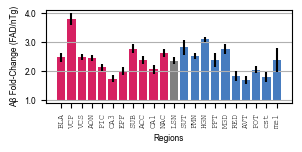

In [7]:
relative_diff = []
relative_diff_sem = []
for i, region in enumerate(regions):
    # Filter data for AD and Non-AD groups for the current region
    ad_data = data[(data['Shorts'] == region) & (data['Gene_condition'] == 'AD')]['Abeta_Mean']
    non_ad_data = data[(data['Shorts'] == region) & (data['Gene_condition'] == 'Non-AD')]['Abeta_Mean']


    ad_mean = np.mean(ad_data)
    non_ad_mean = np.mean(non_ad_data)


    if non_ad_mean != 0:  # Avoid division by zero
        relative_diff.append((ad_mean / non_ad_mean)-1)
        
        combined_data = []
        num = np.array(ad_data)
        denom = np.array(non_ad_data)
        for i in range(len(denom)):
            combined_data.append(num/denom[i])

        temp=np.array(combined_data) 
        relative_diff_sem.append(np.std(temp)/(np.sqrt(len(num)*len(denom))))
    else:
        relative_diff.append(np.nan)  # Handle zero denominator case

plt.rcParams['svg.fonttype'] = 'none'  # Keep SVG text editable
# Define figure and axes for plotting
fig, ax = plt.subplots(figsize=(3, 1.5))

# Plot the relative difference
ax.bar(regions[0:11], relative_diff[0:11], color=red,bottom=1,yerr=relative_diff_sem[0:11])
ax.bar(regions[11], relative_diff[11], color='grey',bottom=1,yerr=relative_diff_sem[11])
ax.bar(regions[12:], relative_diff[12:], color=blue,bottom=1,yerr=relative_diff_sem[12:])
ax.grid(axis='y',zorder=0)

# Customize plot appearance
ax.set_xticks(np.arange(len(regions)))
ax.set_ylim(1*0.9,4*(1+0.1/4))

#adjusted_region=regions.copy()
#adjusted_region[-9]='FMN'

lin_dat=np.linspace(1,4,4)
ax.set_yticks(lin_dat)
ax.set_yticklabels(lin_dat,fontsize=6, fontname='Arial')

#ax.set_xticklabels(adjusted_region, rotation=90, fontsize=6, fontname='Courier New')
ax.set_xticklabels(regions, rotation=90, fontsize=6, fontname='Courier New')
ax.set_xlabel('Regions', fontsize=6, fontname='Arial')
ax.set_ylabel('Aβ Fold-Change (FAD/nTg)', fontsize=6, fontname='Arial')

save_path = '../Investigating_Yuqi_Data/Running_Python_Outputs/Abeta_FoldChange_AD_non_AD.svg'
plt.savefig(save_path, dpi=600)

# Display plot
plt.tight_layout()
plt.show()

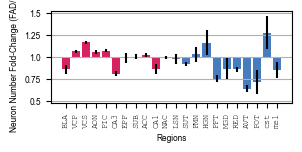

In [8]:
relative_diff = []
relative_diff_sem = []
for i, region in enumerate(regions):
    # Filter data for AD and Non-AD groups for the current region
    ad_data = data[(data['Shorts'] == region) & (data['Gene_condition'] == 'AD')]['NeuN_num']
    non_ad_data = data[(data['Shorts'] == region) & (data['Gene_condition'] == 'Non-AD')]['NeuN_num']


    ad_mean = np.mean(ad_data)
    non_ad_mean = np.mean(non_ad_data)


    if non_ad_mean != 0:  # Avoid division by zero
        #relative_diff.append((ad_mean - non_ad_mean) / non_ad_mean)
        relative_diff.append((ad_mean / non_ad_mean)-1)
        combined_data = []
        num = np.array(ad_data)
        denom = np.array(non_ad_data)
        for i in range(len(denom)):
            combined_data.append(num/denom[i])

        temp=np.array(combined_data) 
        relative_diff_sem.append(np.std(temp)/(np.sqrt(len(num)*len(denom))))
    else:
        relative_diff.append(np.nan)  # Handle zero denominator case

plt.rcParams['svg.fonttype'] = 'none'  # Keep SVG text editable
# Define figure and axes for plotting
fig, ax = plt.subplots(figsize=(3,1.5))

# Plot the relative difference
ax.bar(regions[0:11], relative_diff[0:11], color=red,bottom=1,yerr=relative_diff_sem[0:11])
ax.bar(regions[11], relative_diff[11], color='grey',bottom=1,yerr=relative_diff_sem[11])
ax.bar(regions[12:], relative_diff[12:], color=blue,bottom=1,yerr=relative_diff_sem[12:])
ax.grid(axis='y',zorder=0)

# Customize plot appearance
ax.set_xticks(np.arange(len(regions)))
ax.set_ylim(0.5*0.95,1.5+(0.5-0.5*0.95))

#adjusted_region=regions.copy()
#adjusted_region[-9]='FMN'

lin_dat=np.linspace(0.5,1.5,5)
ax.set_yticks(lin_dat)
ax.set_yticklabels(lin_dat,fontsize=6, fontname='Arial')

#ax.set_xticklabels(adjusted_region, rotation=90, fontsize=6, fontname='Courier New')
ax.set_xticklabels(regions, rotation=90, fontsize=6, fontname='Courier New')
ax.set_xlabel('Regions', fontsize=6, fontname='Arial')
ax.set_ylabel('Neuron Number Fold-Change (FAD/nTg)', fontsize=6, fontname='Arial')

save_path = '../Investigating_Yuqi_Data/Running_Python_Outputs/Neuron_Number_FoldChange_AD_non_AD.svg'
plt.savefig(save_path, dpi=600)

# Display plot
plt.tight_layout()
plt.show()

In [9]:
# Grab increase and decrease regions associated with Volume mm3 -- no tracts included -- removing regions where the abs (% change) <1%
val=df[df['Contrast']=='volume_mm3']['Relative_Diff wrt nTG']>0.01
true_indices = [i for i, val in enumerate(val) if val is True]
val=df[df['Contrast']=='volume_mm3']['Relative_Diff wrt nTG']<-0.01
false_indices = [i for i, val in enumerate(val) if val is True]

region_increase=[]
region_decrease=[]

for i, true_idx in enumerate(true_indices):
    if regions[true_indices[i]].isupper():
        region_increase.append(regions[true_indices[i]])
for i, decrease_idx in enumerate(false_indices):
    if regions[false_indices[i]].isupper():
        region_decrease.append(regions[false_indices[i]])
        
        
custom_regions = {
    'Increase': region_increase,  
    'Decrease': region_decrease
}

print(custom_regions)

{'Increase': ['BLA', 'VCP', 'VCS', 'AON', 'PIC', 'CA3', 'EPF', 'SUB', 'ACC', 'CA1', 'NAC'], 'Decrease': ['SUT', 'FMN', 'HGN', 'PFT', 'MGD', 'RED', 'AVT', 'POT']}


In [10]:
#Shape Pvalues into useful form and find the Fisher combined pvalues
data_keep_combined = [{}]

metrics = {
    'NeuN_num': 'Neuron number',
    'Abeta_Mean': 'Amyloid beta load',
    'NeuNDensity_Mean': 'Neuron density',
    'volume_mm3': 'Volume'
}

categories=['increase','decrease']

for metric, metric_name in metrics.items(): 
    for i,category in enumerate(categories):
        pvalue=[]
        pvalue_BH=[]
        if category == 'increase':
            for i, ri in enumerate(region_increase):
                
                pvalue.append(df[(df['Abbreviation'] == ri) & (df['Contrast'] == metric)]['Pvalue'])
                pvalue_BH.append(df[(df['Abbreviation'] == ri) & (df['Contrast'] == metric)]['Pvalue_BH'])
                
        elif category == 'decrease':
            for i, rd in enumerate(region_decrease):
                pvalue.append(df[(df['Abbreviation'] == rd) & (df['Contrast'] == metric)]['Pvalue'])
                pvalue_BH.append(df[(df['Abbreviation'] == rd) & (df['Contrast'] == metric)]['Pvalue_BH'])    

        entry={'Contrast': metric,'Category':category,'Fisher_Combined_Pvalue':fisher_combined(pvalue),'Fisher_Combined_Pvalue_BH':fisher_combined(pvalue_BH)}
        data_keep_combined.append(entry)

df_combo = pd.DataFrame(data_keep_combined)
df_combo = df_combo[1:] #cleans out preallocation row
df_combo.to_csv('../Investigating_Yuqi_Data/Running_Python_Outputs/Combined_Pvalue_Results_for_Figure6.csv', index=True)

#By hand version from Yuqi saved in file... comparing with my results to make sure I can replicate her work
#pvalue=[0.18883216240005812,0.6027818865117746,0.04374800066400511,0.5744575980108966,0.15470323014537732,0.008858006556621787,0.2951556490234825]
#fisher_combined(pvalue)

In [11]:
#Do corrleation just of the FAD specimens

file_path='../Investigating_Yuqi_Data/Original_Yuqi_DataSheets/Archive_NeuN_Abeta_Volume_Dec19_removeextrasub.xlsx'
df = pd.read_excel(file_path, sheet_name='Archive_NeuN_Abeta_Volume_Dec19')

val=df['Structure']=='cn7__Facial_motor_nucleus_cranial_nerve_VII_left'
true_indices = [i for i, val in enumerate(val) if val is True]

for i, true_idx in enumerate(true_indices):
    df.loc[true_indices[i], 'Structure']='FMN__Facial_motor_nucleus_left'
    
df = df.rename(columns={
    'NeuNDensity_Mean (*1000)': 'Neuron_Density',
    'NeuN_num_Mean': 'Neuron_Number',
    'volume_mm3': 'Volume',
    'Abeta_Mean': 'Abeta_load'
})

FAD_df=df[df['Gene_condition']=='Tg']
ROI_values=FAD_df['Region'].unique()

# Compute correlations
x_metric='Abeta_load'
y_metric=['volume_normalized', 'Neuron_Density', 'Neuron_Number']
x_compare='A Beta Load in FAD'
y_compare = ['Fractional Volume in FAD', 'Neuron Density in FAD', 'Neuron Number in FAD']

data_out=[{}]
for roi in ROI_values:
    temp_FAD_df=FAD_df[FAD_df['Region']==roi]
    structure_name = temp_FAD_df['Structure'].unique()
    valf=regions_num==roi
    true_indices =np.where(valf)
    
    for i in range(3):
        entry=correlation(temp_FAD_df[x_metric],temp_FAD_df[y_metric[i]],x_compare,y_compare[i],'spearman','-')
        entry.update({'ROI': roi,'Structure':str("").join(structure_name),'Figure X-Position Index': str(true_indices[0]+1)})
        data_out.append(entry)
  
df_out = pd.DataFrame(data_out)
df_out = df_out[1:] #cleans out preallocation row

H0, Pvalue_BH,Sidak_Alpha,Bonferroni_Alpha=multipletests(df_out['pvalue'], alpha=0.05, method='fdr_bh')
df_out.insert(loc=6, column='Pvalue_BH', value=Pvalue_BH)
H0, Pvalue_Bonferroni,Sidak_Alpha,Bonferroni_Alpha=multipletests(df_out['pvalue'], alpha=0.05, method='bonferroni')
df_out.insert(loc=6, column='Pvalue_Bonferroni', value=Pvalue_Bonferroni)

df_out.to_csv('../Investigating_Yuqi_Data/Running_Python_Outputs/Lightsheet_Regional_Correlation_OnlyFAD_spearman.csv', index=True)

In [12]:
df_out

,x_metric,y_metric,additional_delineation,correlation type,rho,pvalue,Pvalue_Bonferroni,Pvalue_BH,ROI,Structure,Figure X-Position Index
1,A Beta Load in FAD,Fractional Volume in FAD,-,spearman,0.350000,0.355820,1.000000,0.546142,4.0,AON__Anterior_olfactory_nucleus_left,[4]
2,A Beta Load in FAD,Neuron Density in FAD,-,spearman,0.800000,0.009628,0.635443,0.063544,4.0,AON__Anterior_olfactory_nucleus_left,[4]
3,A Beta Load in FAD,Neuron Number in FAD,-,spearman,0.666667,0.049867,1.000000,0.182847,4.0,AON__Anterior_olfactory_nucleus_left,[4]
4,A Beta Load in FAD,Fractional Volume in FAD,-,spearman,-0.400000,0.286105,1.000000,0.472073,9.0,ACC__Anterior_cingulate_cortex_left,[9]
5,A Beta Load in FAD,Neuron Density in FAD,-,spearman,0.700000,0.035770,1.000000,0.147549,9.0,ACC__Anterior_cingulate_cortex_left,[9]
...,...,...,...,...,...,...,...,...,...,...,...
62,A Beta Load in FAD,Neuron Density in FAD,-,spearman,0.100000,0.797972,1.000000,0.863379,168.0,cst__corticospinal_tract_left,[21]
63,A Beta Load in FAD,Neuron Number in FAD,-,spearman,0.000000,1.000000,1.000000,1.000000,168.0,cst__corticospinal_tract_left,[21]
64,A Beta Load in FAD,Fractional Volume in FAD,-,spearman,-0.183333,0.636820,1.000000,0.778335,169.0,mel__medial_lemniscus_left,[22]
65,A Beta Load in FAD,Neuron Density in FAD,-,spearman,0.216667,0.575515,1.000000,0.759680,169.0,mel__medial_lemniscus_left,[22]


(array([21]), array([0]))
